IndexInfoRX connected.
distance=0.20267391304347981m, pfx=3, data=1
distance=0.26245652173913214m, pfx=3, data=2
distance=0.26245652173913214m, pfx=3, data=1
distance=0.26245652173913214m, pfx=3, data=2
distance=0.2668043478260884m, pfx=3, data=1
distance=0.25919565217391494m, pfx=3, data=2
distance=0.2640869565217372m, pfx=3, data=1
distance=0.25702173913043325m, pfx=3, data=2
distance=0.2581086956521723m, pfx=3, data=1
distance=0.2510434782608719m, pfx=3, data=2
distance=0.25376086956521604m, pfx=3, data=1
distance=0.25049999999999883m, pfx=3, data=2
distance=0.24071739130434722m, pfx=3, data=1
distance=0.25213043478260744m, pfx=3, data=2
distance=0.18310869565217303m, pfx=3, data=1
distance=0.25919565217391494m, pfx=3, data=2
distance=0.1738695652173874m, pfx=3, data=1
distance=0.24560869565217303m, pfx=3, data=2
distance=0.17658695652173861m, pfx=3, data=1
distance=0.25919565217391494m, pfx=3, data=2
distance=0.166804347826087m, pfx=3, data=1
distance=0.2928913043478296m, pfx=3, da

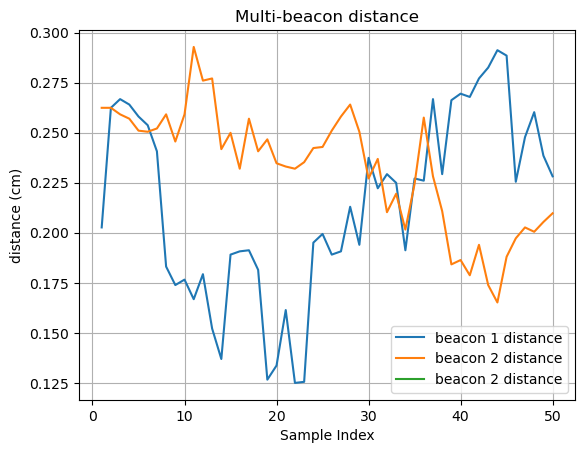

In [ ]:
from range import RangeCalc
import numpy as np
from numpy.fft import rfft
from numpy.fft import fftfreq
from matplotlib import pyplot as plt
import pandas as pd

rc = RangeCalc("COM3", 115200, 10, 30.012)

# Initialize live plot
plt.ion()
fig, ax = plt.subplots()
distance1, index1, distance2, index2, distance3, index3 = [], [], [], [], [], []

line1, = ax.plot(index1, distance1, label="beacon 1 distance")
line2, = ax.plot(index2, distance2, label="beacon 2 distance")
line3, = ax.plot(index3, distance3, label="beacon 3 distance")

ax.set_xlabel("Sample Index")
ax.set_ylabel("distance (cm)")
ax.set_title("Multi-beacon distance")
ax.legend()
ax.grid()
i,i1,i2,i3=0,0,0,0
while i <100:  
    distance, pfx, data = rc.read_range_and_beacon_id()
    i+=1
    print(f"distance={distance}m, pfx={pfx}, data={data}")  # Print the filtered value
    
    # Update plot data
    if data==1:
        distance1.append(distance)
        i1+=1
        index1.append(i1)
    elif data==2:
        distance2.append(distance)
        i2+=1
        index2.append(i2)
    elif data==3:
        distance3.append(distance)
        i3+=1
        index3.append(i3)

    line1.set_xdata(index1)
    line1.set_ydata(distance1)
    line2.set_xdata(index2)
    line2.set_ydata(distance2)
    line3.set_xdata(index3)
    line3.set_ydata(distance3)
    ax.relim()
    ax.autoscale_view()
    plt.draw()
    # plt.pause(0.01)  # Adjust for smoother updates

plt.ioff()
plt.show()
np.savez('distances.npz', arr_1=np.array(distance1), arr_2=np.array(distance2), arr_3=np.array(distance3))

In [7]:
def trilateration_3d(P1, P2, P3, d1, d2, d3):
    # Convert points to numpy arrays
    P1 = np.array(P1)
    P2 = np.array(P2)
    P3 = np.array(P3)

    # Unit vector in direction from P1 to P2
    ex = (P2 - P1)
    ex = ex / np.linalg.norm(ex)

    # Vector from P1 to P3
    P3_P1 = P3 - P1

    # Project P3_P1 onto ex to find i
    i = np.dot(ex, P3_P1)

    # Vector in the P1-P3 plane orthogonal to ex
    temp = P3_P1 - i * ex
    ey = temp / np.linalg.norm(temp)

    # ez is the cross product of ex and ey
    ez = np.cross(ex, ey)

    # Coordinates in new basis
    d = np.linalg.norm(P2 - P1)
    j = np.dot(ey, P3_P1)

    # Coordinates of drone in local coordinate system
    x = (d1**2 - d2**2 + d**2) / (2 * d)
    y = (d1**2 - d3**2 + i**2 + j**2 - 2 * i * x) / (2 * j)

    # Calculate z coordinate
    z_sq = d1**2 - x**2 - y**2
    if z_sq < 0:
        raise ValueError("The spheres do not intersect at a real point (z^2 < 0).")
    z = np.sqrt(z_sq)

    # Convert back to original coordinate system
    coordinates = P1 + x * ex + y * ey + z * ez
    return coordinates


(100, 3)


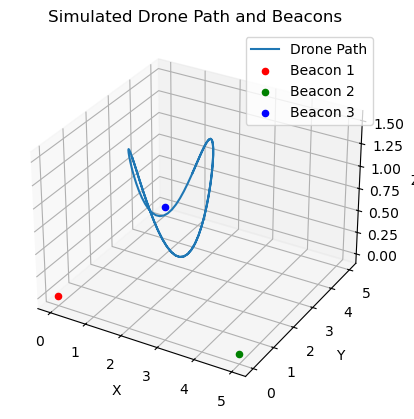

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define beacon positions (fixed)
P1 = np.array([0, 0, 0])
P2 = np.array([5, 0, 0])
P3 = np.array([0, 5, 0])
beacons = [P1, P2, P3]
simulation = 0
if(simulation):
    # Generate drone path: e.g., a helical or sinusoidal path
    t = np.linspace(0, 10, 100)
    drone_path = np.array([
        2 + np.sin(t),       # x
        2 + np.cos(t),       # y
        1 + 0.5 * np.sin(2*t)  # z
    ]).T  # shape (100, 3)

    # Calculate distances to each beacon over time
    distances = np.array([
        [np.linalg.norm(pos - P1),
        np.linalg.norm(pos - P2),
        np.linalg.norm(pos - P3)]
        for pos in drone_path
    ])
    Trilater_drone_path = np.array([trilateration_3d(P1,P2,P3,d[0],d[1],d[2]) for d in distances])


In [ ]:
L = np.min(len(distance1),len(distance2),len(distance3))
Trilater_drone_path = np.zeros((100,3))
for i in range(L):
    Trilater_drone_path[i,:] = trilateration_3d(P1,P2,P3,distance1[i],distance2[i],distance3[i])

# Optional: plot the drone path and beacons
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(Trilater_drone_path[:,0], Trilater_drone_path[:,1], Trilater_drone_path[:,2], label="Drone Path")
ax.scatter(*P1, c='r', label='Beacon 1')
ax.scatter(*P2, c='g', label='Beacon 2')
ax.scatter(*P3, c='b', label='Beacon 3')
ax.legend()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Drone Path and Beacons')
plt.show()
